In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.spatial.distance import pdist, squareform

from umap import UMAP
from dosnes import dosnes

import matplotlib

%matplotlib inline

In [2]:
df = pd.read_csv("../datas/prepared/final_dataset_with_omdb.csv", index_col=0, encoding="ISO-8859-1")

In [3]:
df[df.columns[:-50]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, tt0003037 to tt7889682
Data columns (total 67 columns):
primaryTitle      27406 non-null object
originalTitle     27406 non-null object
startYear         27406 non-null float64
runtimeMinutes    27406 non-null int64
averageRating     27406 non-null float64
numVotes          27406 non-null int64
Action            27406 non-null int64
Adventure         27406 non-null int64
Animation         27406 non-null int64
Biography         27406 non-null int64
Comedy            27406 non-null int64
Crime             27406 non-null int64
Drama             27406 non-null int64
Family            27406 non-null int64
Fantasy           27406 non-null int64
Film-Noir         27406 non-null int64
History           27406 non-null int64
Horror            27406 non-null int64
Musical           27406 non-null int64
Mystery           27406 non-null int64
Romance           27406 non-null int64
Sci-Fi            27406 non-null int64
Sport             27

In [4]:
df[df.columns[-50:]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, tt0003037 to tt7889682
Data columns (total 50 columns):
France            27406 non-null int64
Germany           27406 non-null int64
Hong Kong         27406 non-null int64
India             27406 non-null int64
Italy             27406 non-null int64
Japan             27406 non-null int64
Mexico            27406 non-null int64
Spain             27406 non-null int64
Sweden            27406 non-null int64
Turkey            27406 non-null int64
UK                27406 non-null int64
USA               27406 non-null int64
Lang_En           27406 non-null int64
Lang_Fr           27406 non-null int64
Topic_0           27406 non-null float64
Topic_1           27406 non-null float64
Topic_2           27406 non-null float64
Topic_3           27406 non-null float64
Topic_4           27406 non-null float64
Topic_5           27406 non-null float64
Topic_6           27406 non-null float64
Topic_7           27406 non-null float64
Topic_8   

In [5]:
df = df[df.startYear > 1995]
df.head()

,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,Action,Adventure,Animation,Biography,...,prod_WB,prod_Sony,prod_VCI,prod_Disney,prod_Indep,prod_MGM,prod_Fox,prod_Universal,prod_Lion,prod_Paramount
tconst,,,,,,,,,,,,,,,,,,,,,
tt0035423,Kate & Leopold,Kate & Leopold,2001.0,118,6.4,70611,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0096056,Crime and Punishment,Crime and Punishment,2002.0,126,6.3,567,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0110125,The Cold Light of Day,The Cold Light of Day,1996.0,96,6.4,620,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0112433,Baby Face Nelson,Baby Face Nelson,1996.0,93,5.6,172,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0112444,My Teacher's Wife,My Teacher's Wife,1999.0,89,5.6,1417,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
cmap = matplotlib.cm.get_cmap('gist_rainbow_r')
norm = matplotlib.colors.Normalize(vmin=df["score"].min(), vmax=df["score"].max())

def get_color(x):
    return matplotlib.colors.to_hex(cmap(norm(x)))

df["score"] = df["averageRating"] * np.log(df["numVotes"])
df["color"] = df["score"].apply(get_color)

# Required Scaling

Move to log for too big scale

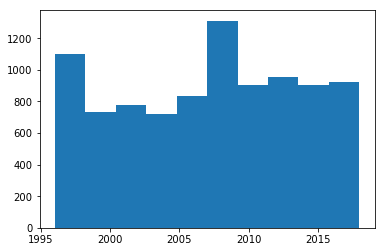

In [6]:
plt.hist(df.startYear)
plt.show()

In [7]:
avg_duration = df[df.runtimeMinutes < 1000].runtimeMinutes.mean()
df.loc[df.runtimeMinutes > 1000, "runtimeMinutes"] = avg_duration

# Encoded version

In [10]:
X = df.drop(["primaryTitle", "originalTitle"], axis=1)

In [11]:
X.numVotes = np.log(X.numVotes)

In [12]:
X.BoxOffice = X.BoxOffice.fillna(1)
X.BoxOffice = np.log(X.BoxOffice)

In [13]:
# a movie with 10 oscar is not 10 times better than a movie with 1 oscar, so a log is also a good but log(n+1) as lot of movies have 0 rewards

X.oscar_won = np.log(X.oscar_won + 1)
X.oscar_nom = np.log(X.oscar_nom + 1)
X.gg_won = np.log(X.gg_won + 1)
X.gg_nom = np.log(X.gg_nom + 1)
X.bafta_won = np.log(X.bafta_won + 1)
X.bafta_nom = np.log(X.bafta_nom + 1)
X.other_win = np.log(X.other_win + 1)
X.other_nom = np.log(X.other_nom + 1)

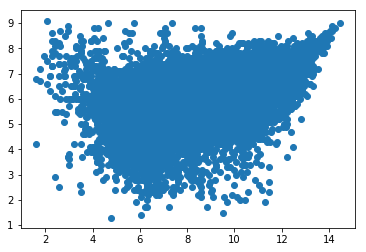

In [14]:
plt.scatter(X.numVotes, X.averageRating)
plt.show()

In [15]:
X["startYear"] = MinMaxScaler().fit_transform(X[["startYear"]])
X["averageRating"] = MinMaxScaler().fit_transform(X[["averageRating"]])
X["Metascore"] = MinMaxScaler().fit_transform(X[["Metascore"]])
X["Score_RT"] = MinMaxScaler().fit_transform(X[["Score_RT"]])

X["runtimeMinutes"] = StandardScaler().fit_transform(X[["runtimeMinutes"]])
X["numVotes"] = StandardScaler().fit_transform(X[["numVotes"]])
X["BoxOffice"] = StandardScaler().fit_transform(X[["BoxOffice"]])

X["oscar_won"] = MinMaxScaler().fit_transform(X[["oscar_won"]])
X["oscar_nom"] = MinMaxScaler().fit_transform(X[["oscar_nom"]])
X["gg_won"] = MinMaxScaler().fit_transform(X[["gg_won"]])
X["gg_nom"] = MinMaxScaler().fit_transform(X[["gg_nom"]])
X["bafta_won"] = MinMaxScaler().fit_transform(X[["bafta_won"]])
X["bafta_nom"] = MinMaxScaler().fit_transform(X[["bafta_nom"]])
X["other_win"] = MinMaxScaler().fit_transform(X[["other_win"]])
X["other_nom"] = MinMaxScaler().fit_transform(X[["other_nom"]])

# for col in df:
#     if col.startswith("Topic_"):
#         X[col] = MinMaxScaler().fit_transform(X[[col]])

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9150 entries, tt0035423 to tt7889682
Columns: 115 entries, startYear to prod_Paramount
dtypes: float64(35), int64(80)
memory usage: 8.4+ MB


# Conversion du Distance Matrices

In [17]:
X['mean'] = X[["averageRating", "Metascore", "Score_RT"]].mean(axis=1)

In [18]:
group0 = ["mean", "numVotes"] # ["averageRating", "numVotes", "Metascore", "Score_RT"]   # 4
group1 = ["startYear", "runtimeMinutes", "BoxOffice"]             # 7
group2 = X.columns[4:24]                                          # 27
group3 = X.columns[X.columns.str.startswith("Cluster_")]          # 37
group4 = X.columns[X.columns.str.startswith("Director_")]         # 45
group5 = X.columns[X.columns.str.startswith("Writer_")]           # 53
group6 = X.columns[X.columns.str.startswith("Topic_")]            # 73
group7 = X.columns[60:79]                                         # 92
group8 = X.columns[X.columns.str.startswith("prod_")]             # 102
group9 = X.columns[52:60]                                         # 110
group10 = X.columns[99:104]                                       # 115

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9150 entries, tt0035423 to tt7889682
Columns: 116 entries, startYear to mean
dtypes: float64(36), int64(80)
memory usage: 8.5+ MB


In [19]:
df[group6] = df[group6].div(df[group6].sum(axis=1), axis=0).fillna(0)

In [20]:
df[group10].head()

,All_age,Min_13,All_PG,Min_16,Min_17
tconst,,,,,
tt0035423,0,1,1,1,1
tt0096056,0,0,0,0,0
tt0110125,0,0,0,0,0
tt0112433,0,0,0,1,1
tt0112444,0,0,0,1,1


In [37]:
d0 = pdist(X[group0], metric='euclidean')  # ranking
d1 = pdist(X[group1], metric='euclidean')  # year, time, BO
d2 = pdist(X[group2], metric='hamming')    # movie style
d3 = pdist(X[group3], metric='hamming')    # cluster actors
d4 = pdist(X[group4], metric='hamming')    # director
d5 = pdist(X[group5], metric='hamming')    # writer
d6 = pdist(X[group6], metric="braycurtis") # Topic
d7 = pdist(X[group7], metric='hamming')    # country
d8 = pdist(X[group8], metric='hamming')    # distrib
d9 = pdist(X[group9], metric='Minkowski', p=2**0.5)  # win
d10= pdist(X[group10], metric='hamming')   # rated

In [52]:
d6 = np.nan_to_num(d6)

In [55]:
d0 = (d0-d0.min())/d0.max()
d1 = (d1-d1.min())/d1.max()
d2 = (d2-d2.min())/d2.max()
d3 = (d3-d3.min())/d3.max()
d4 = (d4-d4.min())/d4.max()
d5 = (d5-d5.min())/d5.max()
d6 = (d6-d6.min())/d6.max()
d7 = (d7-d7.min())/d7.max()
d8 = (d8-d8.min())/d8.max()
d9 = (d9-d9.min())/d9.max()
d10 = (d10-d10.min())/d10.max()

In [56]:
np.savez_compressed('distance_matrices', d0=d0, d1=d1, d2=d2, d3=d3, d4=d4, d5=d5, d6=d6, d7=d7, d8=d8, d9=d9, d10=d10)

# Loading data

In [2]:
X = np.load('distance_matrices.npz')

d0 = X["d0"]
d1 = X["d1"]
d2 = X["d2"]
d3 = X["d3"]
d4 = X["d4"]
d5 = X["d5"]
d6 = X["d6"]
d7 = X["d7"]
d8 = X["d8"]
d9 = X["d9"]
d10 = X["d10"]

In [3]:
distance_final = 1.5 * d0 + 0.3 * d1 + 10 * d2 + 0.3 * d3 + 0.2 * d4 + 0.2 * d5 + 0.8 * d6 + 0.8 * d7 + 1 * d8 + 0.2 * d9 + 0.5 * d10

In [4]:
del X
del d0
del d1
del d2
del d3
del d4
del d5
del d6
del d7
del d8
del d9
del d10

In [5]:
print(distance_final.min())
print(distance_final.max())

0.029191319461
13.723582915


In [6]:
distance_final = squareform(distance_final)

# UMAP

In [34]:
model = UMAP(metric="precomputed", 
             n_neighbors=50, 
             n_components=3,
             local_connectivity = 3
            )
pos = model.fit_transform(distance_final)

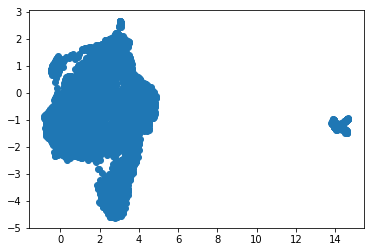

In [35]:
plt.scatter(pos[:,0], pos[:,1])
plt.show()

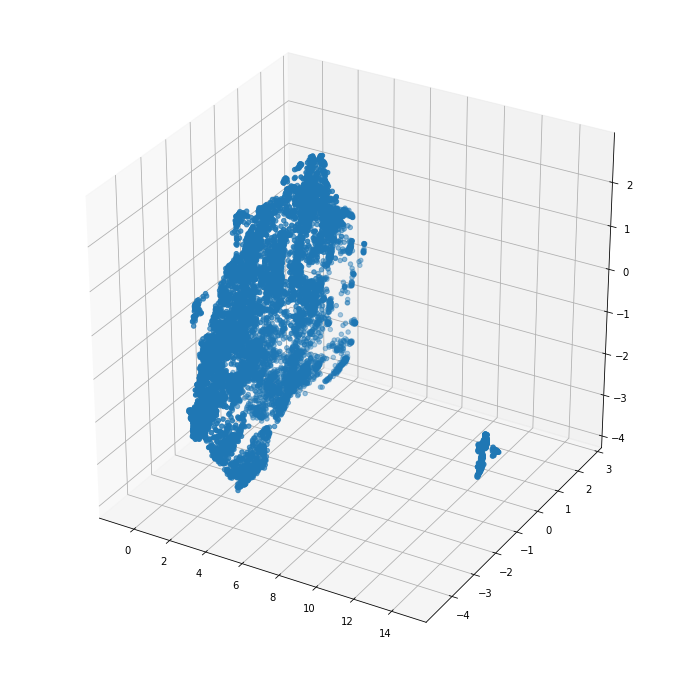

In [36]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2])
plt.show()

In [37]:
index = (pos[:, 0] > 10)
df[index]

,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,Action,Adventure,Animation,Biography,...,prod_WB,prod_Sony,prod_VCI,prod_Disney,prod_Indep,prod_MGM,prod_Fox,prod_Universal,prod_Lion,prod_Paramount
tconst,,,,,,,,,,,,,,,,,,,,,
tt0113721,My Woman Is Leaving Me,Ma femme me quitte,1996.0,90.000000,4.0,70,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0115549,Anna Oz,Anna Oz,1996.0,98.000000,5.9,132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0115598,Les aveux de l'innocent,Les aveux de l'innocent,1996.0,90.000000,6.6,51,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0116053,Deadly Charades,Deadly Charades,1996.0,92.000000,4.2,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0116091,Two Dads and One Mom,Les 2 papas et la maman,1996.0,90.000000,2.7,231,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0116432,Golden Boy,Golden Boy,1996.0,91.000000,4.0,78,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0116455,Young and Dangerous 3,Goo waak zai 3: Jek sau je tin,1996.0,98.000000,6.7,776,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0116887,Line of Life,Ligne de vie,1996.0,100.000000,6.3,92,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0116991,Mariette in Ecstasy,Mariette in Ecstasy,1996.0,103.462255,7.7,28,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TSNE

In [88]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, 
                  perplexity=50.0, 
                  early_exaggeration=12.0, 
                  learning_rate=200.0, 
                  n_iter=1000, 
                  n_iter_without_progress=300, 
                  min_grad_norm=1e-07, 
                  metric="precomputed", 
                  init="random", 
                  verbose=0, 
                  random_state=None, 
                  method="barnes_hut", 
                  angle=0.5
                 ).fit_transform(distance_final)

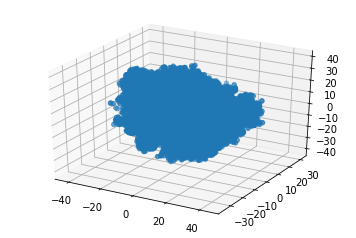

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2])
plt.show()

# DOSNES

In [12]:
mdl = dosnes.DOSNES(metric = "precomputed", verbose = 1)
X_embedded = mdl.fit_transform(distance_final)

Set doubly Stochastic
Start Embedding
Iteration 0 : error is 0.40764513813281056
Iteration 10 : error is 0.40764513811159375
Iteration 20 : error is 0.40764513294966065
Iteration 30 : error is 0.40756488319903283
Iteration 40 : error is 0.21020904333036228
Iteration 50 : error is 0.18667733879420823
Iteration 60 : error is 0.18659323965908925
Iteration 70 : error is 0.1862719908760866
Iteration 80 : error is 0.18577172225817762
Iteration 90 : error is 0.18541218094499712
Iteration 100 : error is 0.18521055431201816
Iteration 110 : error is 0.1850531009990526
Iteration 120 : error is 0.1849427835170303
Iteration 130 : error is 0.1848592521911847
Iteration 140 : error is 0.18478521634212086
Iteration 150 : error is 0.184734042114588
Iteration 160 : error is 0.1846887894853495
Iteration 170 : error is 0.18464567556269174
Iteration 180 : error is 0.1846004228170628
Iteration 190 : error is 0.18456802648613646
Iteration 200 : error is 0.1845373764316136
Iteration 210 : error is 0.1845169847

In [13]:
X_embedded = mdl.embedding

In [14]:
to_save = df[["primaryTitle"]].reset_index()
to_save["score"] = df.averageRating.values * df.numVotes.values
pos = pd.DataFrame(X_embedded)
pos.columns = ["X", "Y", "Z"]
end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)
end.to_csv("../datas/simulation/dosnes2.csv")

In [37]:
end = pd.read_csv("../datas/simulation/dosnes2.csv", index_col=0, encoding="ISO-8859-1")

In [38]:
end.drop("score", axis=1, inplace=True)
end = end.set_index("tconst").join(df[["score", "color"]]).reset_index()

# end = pd.read_csv("../datas/simulation/dosnes2.csv", index_col=0, encoding="ISO-8859-1")
end.to_json("../datas/simulation/dosnes2.json")

In [39]:
file = "../datas/simulation/dosnes2.json"
base = os.path.basename(file)[:-5]
out_path = "../datas/simulation/"+base+"_2.json"
with open(file, "r") as f, open(out_path, "w") as g:
    content = f.read()
    content = content.replace("\'", "\\\'")
    final_content = "var data = '" + content + "';"
    g.write(final_content)

## New weight (10 on topics)

In [10]:
distance_final.max()

13.72358291497906

In [ ]:
mdl = dosnes.DOSNES(metric = "precomputed", verbose = 1)
X_embedded = mdl.fit_transform(distance_final)

Set doubly Stochastic


In [ ]:
to_save = df[["primaryTitle"]].reset_index()
to_save["score"] = df.averageRating.values * df.numVotes.values
pos = pd.DataFrame(X_embedded)
pos.columns = ["X", "Y", "Z"]
end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)
end.to_csv("../datas/simulation/dosnes_new_weight.csv")

In [5]:
end = pd.read_csv("../datas/simulation/dosnes_new_weight.csv", index_col=0, encoding="ISO-8859-1")
datas = pd.read_csv("../datas/raw/full_omdb.csv", index_col=0, encoding="ISO-8859-1")

In [8]:
datas.head()

,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,Poster,...,Response,Runtime,Title,Type,Website,Writer,Year,imdbID,imdbRating,imdbVotes
Actors,,,,,,,,,,,,,,,,,,,,,
"Pola Negri, Emil Jannings, Harry Liedtke, Eduard von Winterstein",NaN,NaN,Germany,NaN,Ernst Lubitsch,"Biography, Drama",German,NaN,"The story of Madame DuBarry, the mistress of L...",https://images-na.ssl-images-amazon.com/images...,...,True,85 min,Madame DuBarry,movie,NaN,"Norbert Falk, Hanns Kräly",1919,tt0002423,6.9,565
"René Navarre, Edmund Breon, Georges Melchior, Renée Carl",1 nomination.,NaN,France,NaN,Louis Feuillade,"Crime, Drama",French,NaN,In Part Two of Louis Feuillade's 5 1/2-hour ep...,https://images-na.ssl-images-amazon.com/images...,...,True,61 min,Fantômas: Juve versus Fantômas,movie,NaN,"Marcel Allain (novel), Louis Feuillade, Pierre...",1913,tt0003037,6.8,"1,057"
"René Navarre, Edmund Breon, Georges Melchior, Luitz-Morat",1 nomination.,NaN,France,NaN,Louis Feuillade,"Crime, Drama, Mystery",French,NaN,After a body disappears from inside the prison...,https://images-na.ssl-images-amazon.com/images...,...,True,90 min,Fantômas: The Dead Man Who Killed,movie,NaN,"Marcel Allain (novel), Louis Feuillade, Pierre...",1913,tt0003165,6.9,817
"Henry B. Walthall, Spottiswoode Aitken, Blanche Sweet, George Siegmann",NaN,NaN,USA,18 Nov 2008,D.W. Griffith,"Crime, Drama",English,NaN,"Objected to date his sweetheart by his uncle, ...",https://images-na.ssl-images-amazon.com/images...,...,True,78 min,The Avenging Conscience: or 'Thou Shalt Not Kill',movie,NaN,"Edgar Allan Poe (stories), D.W. Griffith",1914,tt0003643,6.9,884
"René Navarre, Edmund Breon, Georges Melchior, Mesnery",1 nomination.,NaN,France,NaN,Louis Feuillade,"Crime, Drama",French,NaN,Fantômas has been arrested and is jailed in Br...,https://images-na.ssl-images-amazon.com/images...,...,True,70 min,Fantômas: The False Magistrate,movie,NaN,"Marcel Allain (novel), Louis Feuillade, Pierre...",1914,tt0003952,6.9,732


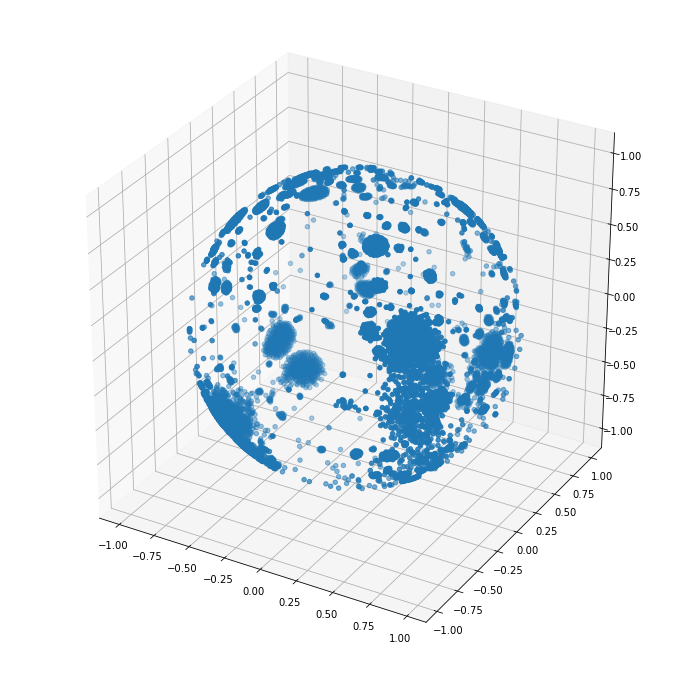

In [10]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(end["X"], end["Y"], end["Z"])
plt.show()

In [20]:
# end.set_index("tconst").join(datas[["Genre", "imdbRating"]], on="imdbID").reset_index()
temp = pd.merge(end, datas[["imdbID", "Genre"]], how = 'left', left_on = 'tconst', right_on = 'imdbID').drop("imdbID", axis=1)
temp = pd.merge(temp, df.reset_index()[["tconst", "averageRating"]], how = 'left', on = "tconst").set_index("tconst")

In [44]:
temp.head()

,primaryTitle,color,score,X,Y,Z,Genre,averageRating
tconst,,,,,,,,
tt0468569,The Dark Knight,#e5fe75,130.116616,-0.673787,0.347325,0.652209,"Action, Crime, Thriller",9.0
tt0167260,The Lord of the Rings: The Return of the King,#e7fd71,125.806130,-0.824094,0.475581,0.307719,"Adventure, Drama, Fantasy",8.9
tt0137523,Fight Club,#e8fc6c,125.403171,0.790532,-0.568028,-0.228918,Drama,8.8
tt0120737,The Lord of the Rings: The Fellowship of the Ring,#e8fc6c,124.516133,-0.821460,0.477598,0.311613,"Adventure, Drama, Fantasy",8.8
tt0133093,The Matrix,#eafa66,123.033620,-0.567806,0.028930,0.822654,"Action, Sci-Fi",8.7


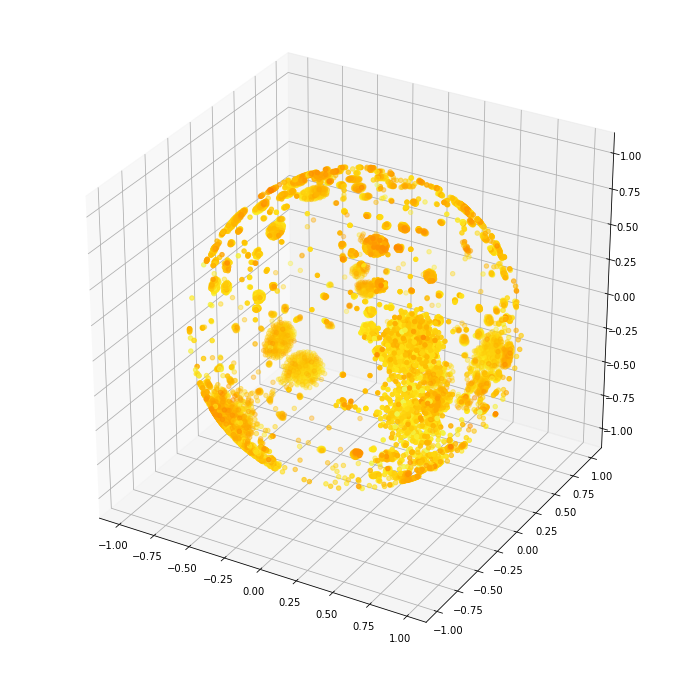

In [38]:
cmap = matplotlib.cm.get_cmap('Wistia_r')
norm = matplotlib.colors.Normalize(vmin=temp["averageRating"].min(), vmax=temp["averageRating"].max())

def get_color(x):
    return matplotlib.colors.to_hex(cmap(norm(x)))

temp["color"] = temp["averageRating"].apply(get_color)

In [55]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(temp["X"], temp["Y"], temp["Z"], c=temp["averageRating"], cmap="Wistia_r")
ax.scatter(temp["X"], temp["Y"], temp["Z"], c=temp["Genre"].str.contains("Drama"))
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

In [53]:
# temp.to_csv("../datas/simulation/dosnes_new_weight_2.csv")

In [10]:
file = "../datas/simulation/mdl_v4.json"
temp.reset_index().to_json("../datas/simulation/mdl_v4.json")
base = os.path.basename(file)[:-5]
out_path = "../datas/simulation/"+base+"_2.json"
with open(file, "r") as f, open(out_path, "w") as g:
    content = f.read()
    content = content.replace("\'", "\\\'")
    final_content = "var data = '" + content + "';"
    g.write(final_content)

In [2]:
temp = pd.read_csv("../datas/simulation/dosnes_new_weight_2.csv", index_col=0, encoding="ISO-8859-1")

In [3]:
a = temp["Genre"].str.get_dummies(sep=", ")

For n_clusters = 30 The average silhouette_score is : 0.431789841154
For n_clusters = 33 The average silhouette_score is : 0.435174222972
For n_clusters = 36 The average silhouette_score is : 0.434221473887
For n_clusters = 39 The average silhouette_score is : 0.433211981343
For n_clusters = 42 The average silhouette_score is : 0.441812446253
For n_clusters = 45 The average silhouette_score is : 0.454410295504
For n_clusters = 48 The average silhouette_score is : 0.451359701207
For n_clusters = 51 The average silhouette_score is : 0.451178644875
For n_clusters = 54 The average silhouette_score is : 0.448961849234
For n_clusters = 57 The average silhouette_score is : 0.458021038707
For n_clusters = 60 The average silhouette_score is : 0.464374392138
For n_clusters = 63 The average silhouette_score is : 0.457662134853
For n_clusters = 66 The average silhouette_score is : 0.458591235698
For n_clusters = 69 The average silhouette_score is : 0.463106778963
For n_clusters = 72 The average si

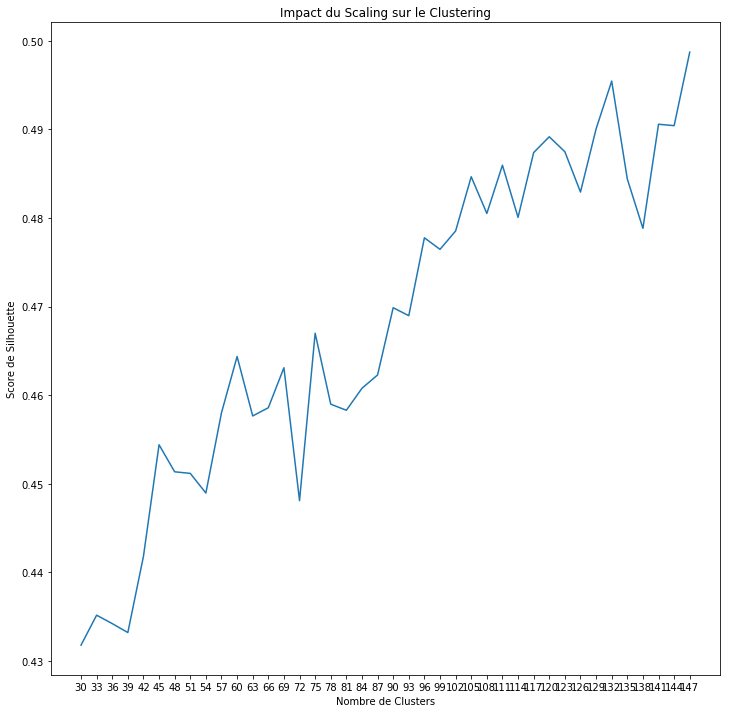

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

score = []
x = list(range(30,150,3))
for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(temp[["X", "Y", "Z"]])
    clusters = kmeans.predict(temp[["X", "Y", "Z"]])
    silhouette_avg = silhouette_score(temp[["X", "Y", "Z"]], clusters)
    score.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    

plt.figure(figsize=(12,12))
plt.plot(x, score)
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.title("Impact du Scaling sur le Clustering")
plt.xticks(x)
plt.show()

In [15]:
n_clusters = 120
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(temp[["X", "Y", "Z"]])
clusters = kmeans.predict(temp[["X", "Y", "Z"]])
silhouette_avg = silhouette_score(temp[["X", "Y", "Z"]], clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 120 The average silhouette_score is : 0.49612128734


(array([  72.,  177.,   94.,   75.,  109.,  208.,   78.,  155.,   79.,
          45.,  156.,  100.,  119.,   44.,   24.,  155.,   75.,  105.,
          49.,   54.,  127.,  101.,  112.,   32.,  170.,  115.,   51.,
          42.,   44.,  134.,   33.,  189.,   59.,  219.,   51.,   26.,
          93.,   23.,   27.,   20.,   70.,   17.,   46.,  115.,  143.,
          69.,   21.,  195.,  125.,  129.,   61.,  119.,  122.,   26.,
          80.,  103.,  170.,   88.,  139.,   33.,   24.,   61.,   67.,
          76.,   29.,  117.,   51.,   11.,   68.,  102.,   31.,   13.,
          58.,   21.,   22.,  166.,   15.,   31.,   95.,   13.,   62.,
          43.,   58.,   38.,   74.,   42.,   14.,   61.,  192.,   78.,
         111.,   50.,   50.,   80.,   24.,  146.,   12.,   39.,   54.,
          25.,  170.,  116.,  140.,   26.,   23.,   75.,  158.,   92.,
          42.,  146.,   69.,   32.,   38.,   19.,   93.,   13.,    6.,
          17.,   39.]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    

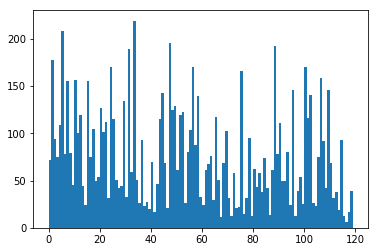

In [22]:
plt.hist(clusters, bins = n_clusters-1)

In [48]:
# from sklearn.cluster import DBSCAN
# db = DBSCAN(eps=1e-5, min_samples=5, metric="euclidean", metric_params=None, algorithm="auto", leaf_size=30, p=None, n_jobs=1)
# clusters = db.fit_predict(temp[["X", "Y", "Z"]])

from sklearn.cluster import AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=100, affinity="euclidean", memory=None, connectivity=None, compute_full_tree="auto", linkage="ward")
clusters = ag.fit_predict(temp[["X", "Y", "Z"]])

# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=100, covariance_type='full')
# gm.fit(temp[["X", "Y", "Z"]])
# clusters = gm.predict(temp[["X", "Y", "Z"]])


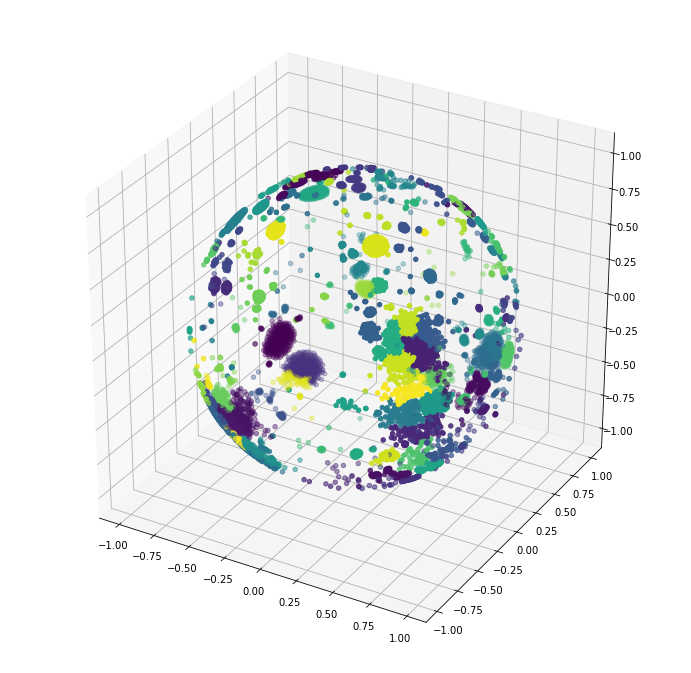

In [49]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(temp["X"], temp["Y"], temp["Z"], c=temp["averageRating"], cmap="Wistia_r")
ax.scatter(temp["X"], temp["Y"], temp["Z"], c=clusters)
plt.show()

# TSNE 2D + projection orthographique

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import TSNE

param_grid = {'perplexity': [2, 10, 30, 50, 100], 
              'learning_rate': [10, 100, 500],
              'n_components' : [2],
              'n_iter' : [500],
              'metric' : ["precomputed"]
             }

to_save = df[["primaryTitle"]].reset_index()
to_save["score"] = df.averageRating.values * np.log(df.numVotes.values)

for param in list(ParameterGrid(param_grid))[1:]:
    tsne = TSNE(**param)
    X_embedded = tsne.fit_transform(distance_final)
    print(param, tsne.n_iter_ , tsne.kl_divergence_)
    pos = pd.DataFrame(X_embedded)
    pos.columns = ["X", "Y"]
    end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)
    end.to_csv("../datas/simulation/TSNE2D-perplexite{}-lr{}.csv".format(param["perplexity"], param["learning_rate"]))

{'learning_rate': 10, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 10} 499 3.8595237731933594
{'learning_rate': 10, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 30} 499 3.2398831844329834
{'learning_rate': 10, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 50} 499 2.7403082847595215
{'learning_rate': 10, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 100} 499 2.315335512161255
{'learning_rate': 100, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 2} 499 2.944429874420166
{'learning_rate': 100, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 10} 499 2.9100253582000732
{'learning_rate': 100, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 30} 499 2.60526967048645
{'learning_rate': 100, 'metric': 'precomputed', 'n_components': 2, 'n_iter': 500, 'perplexity': 50} 499 2.428952217102051
{'learning_rate': 100, 'm

In [19]:
end.head()

,tconst,primaryTitle,score,X,Y
0,tt0468569,The Dark Knight,17100639.0,7.951754,29.706095
1,tt0137523,Fight Club,13593632.8,13.018658,10.465145
2,tt0120737,The Lord of the Rings: The Fellowship of the Ring,12290194.4,22.002222,28.104294
3,tt0167260,The Lord of the Rings: The Return of the King,12256554.9,21.929657,28.166382
4,tt0133093,The Matrix,12056547.0,14.291372,31.779564


In [40]:
for file in glob.glob("../datas/simulation/TSNE2D-perplexite*-lr*.csv"):
    base = os.path.basename(file)[:-4]
    out_path = "../datas/simulation/"+base+".json"
    end = pd.read_csv(file, index_col=0, encoding="ISO-8859-1")
    
    max_y = max(end.Y.max(), abs(end.Y.min()))
    scaling = math.pi / ( 4 * max_y )

    end.Y *= scaling
    end.X *= scaling
    
    x = (2 * end.X) / (1 + end.X**2 + end.Y**2)
    y = (2 * end.Y) / (1 + end.X**2 + end.Y**2)
    z = (end.X**2 + end.Y**2 - 1) / (1 + end.X**2 + end.Y**2)

    end["X"] = x
    end["Y"] = y
    end["Z"] = z
    
    end.drop("score", axis=1, inplace=True)
    end = end.set_index("tconst").join(df[["score", "color"]]).reset_index()
    
    end.to_json(out_path)
    
for file in glob.glob("../datas/simulation/TSNE2D-perplexite*-lr*.json"):
    base = os.path.basename(file)[:-5]
    out_path = "../datas/simulation/"+base+"_2.json"
    with open(file, "r") as f, open(out_path, "w") as g:
        content = f.read()
        content = content.replace("\'", "\\\'")
        final_content = "var data = '" + content + "';"
        g.write(final_content)

# SAVE CSV

In [111]:
to_save = df[["primaryTitle"]].reset_index()

In [49]:
# style = df.columns[6:26] 
# df[style].idxmax(axis=1).value_counts().sum()
# pd.Series(df[style], dtype='category')

9150

In [112]:
to_save["score"] = df.averageRating.values * df.numVotes.values

In [113]:
pos = pd.DataFrame(X_embedded)
pos.columns = ["X", "Y", "Z"]

In [114]:
end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)

In [106]:
end.to_csv("perplexite50.csv")

# Automation

In [10]:
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import TSNE

param_grid = {'perplexity': [2, 10, 30, 50, 100], 
              'learning_rate': [10, 100, 500],
              'n_components' : [3],
              'n_iter' : [500],
              'metric' : ["precomputed"]
             }

to_save = df[["primaryTitle"]].reset_index()
to_save["score"] = df.averageRating.values * df.numVotes.values

for param in list(ParameterGrid(param_grid))[1:]:
    tsne = TSNE(**param)
    X_embedded = tsne.fit_transform(distance_final)
    print(param, tsne.n_iter_ , tsne.kl_divergence_)
    pos = pd.DataFrame(X_embedded)
    pos.columns = ["X", "Y", "Z"]
    end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)
    end.to_csv("../datas/simulation/perplexite{}-lr{}.csv".format(param["perplexity"], param["learning_rate"]))


KeyboardInterrupt: 

# Export JSON

In [8]:
end = pd.read_csv("perplexite30.csv", index_col=0, encoding="ISO-8859-1")

In [108]:
end.head()

,tconst,primaryTitle,score,X,Y,Z
0,tt0468569,The Dark Knight,17100639.0,20.733547,-13.353313,-7.106080
1,tt0137523,Fight Club,13593632.8,-5.088104,23.465616,5.566605
2,tt0120737,The Lord of the Rings: The Fellowship of the Ring,12290194.4,20.499741,-6.989878,-23.846405
3,tt0167260,The Lord of the Rings: The Return of the King,12256554.9,20.642408,-6.490191,-23.236458
4,tt0133093,The Matrix,12056547.0,31.128233,-1.478713,-16.222563


In [9]:
end.to_json("../datas/new_model30.json")

In [84]:
import glob
import os

for file in glob.glob("../datas/simulation/perplexite*-lr*.csv"):
    base = os.path.basename(file)[:-4]
    out_path = "../datas/simulation/"+base+".json"
    end = pd.read_csv(file, index_col=0, encoding="ISO-8859-1")
    end.to_json(out_path)

In [85]:
for file in glob.glob("../datas/simulation/perplexite*-lr*.json"):
    base = os.path.basename(file)[:-5]
    out_path = "../datas/simulation/"+base+"_2.json"
    with open(file, "r") as f, open(out_path, "w") as g:
        content = f.read()
        content = content.replace("\'", "\\\'")
        final_content = "var data = '" + content + "';"
        g.write(final_content)

In [86]:
# Finale training

tsne = TSNE(n_components=3, 
                  perplexity=100.0, 
                  early_exaggeration=12.0, 
                  learning_rate=100.0, 
                  n_iter=1000, 
                  n_iter_without_progress=300, 
                  min_grad_norm=1e-07, 
                  metric="precomputed", 
                  init="random", 
                  verbose=0, 
                  random_state=None, 
                  method="barnes_hut", 
                  angle=0.5
                 )
X_embedded = tsne.fit_transform(distance_final)

In [87]:
print(param, tsne.n_iter_ , tsne.kl_divergence_)

{'learning_rate': 500, 'metric': 'precomputed', 'n_components': 3, 'n_iter': 500, 'perplexity': 100} 999 1.8154692649841309


In [88]:
to_save = df[["primaryTitle"]].reset_index()
to_save["score"] = df.averageRating.values * df.numVotes.values
pos = pd.DataFrame(X_embedded)
pos.columns = ["X", "Y", "Z"]
end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)
end.to_csv("../datas/simulation/perplexite{}-lr{}_final.csv".format(param["perplexity"], param["learning_rate"]))

for file in glob.glob("../datas/simulation/perplexite*-lr*_final.csv"):
    base = os.path.basename(file)[:-4]
    out_path = "../datas/simulation/"+base+".json"
    end = pd.read_csv(file, index_col=0, encoding="ISO-8859-1")
    end.to_json(out_path)
    
for file in glob.glob("../datas/simulation/perplexite*-lr*_final.json"):
    base = os.path.basename(file)[:-5]
    out_path = "../datas/simulation/"+base+"_2.json"
    with open(file, "r") as f, open(out_path, "w") as g:
        content = f.read()
        content = content.replace("\'", "\\\'")
        final_content = "var data = '" + content + "';"
        g.write(final_content)